In [1]:
# import scipy.io as sio
# from scipy.io import arff
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# import pandas as pd
# import csv
# import io
# import math
# import statistics
# from sklearn.decomposition import PCA
# from sklearn import tree
# from sklearn import ensemble
# from sklearn import neighbors
# from sklearn import svm
# from IPython.display import display
# from sklearn.model_selection import GridSearchCV
# from scipy.linalg import svd
# %config InlineBackend.figure_format = 'retina'

import pandas as pd

# 1. Preparing Dataset

In [2]:
red_df = pd.read_csv("winequality_red.csv")
white_df = pd.read_csv("https://raw.githubusercontent.com/abisarvepalli/cogs109-final-project/master/winequality_white.csv")

In [3]:
red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# Merge the `red whine` and `white wine` datasets together into a Dataframe
# red_df['type'] = 0
# white_df['type'] = 1
# dat = pd.concat([red_df, white_df])
dat = pd.concat([red_df])

In [5]:
# concatenate custom feature
dat['high_worth'] = 1
dat.high_worth[dat['quality'] < 8] = 0

"number of features: " + str(len(dat.columns))

/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'number of features: 13'

In [6]:
Y_features = ['quality','high_worth']
X_features = [c for c in dat.columns.tolist() if c not in Y_features]

Y_features = ['quality']

In [7]:
print("Y_features", len(Y_features), Y_features)
print("X_features", len(X_features), X_features)

Y_features 1 ['quality']
X_features 11 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Artifacts:
- `red_df`: pandas DataFrame of red wine
- `white_df`: pandas DataFrame of white wine
- `X_features`: independent features of table
- `Y_features`: dependent feature to be predicted by the model

# 2. Explore the Dataset

## 2.1 Understanding the Features
- `fixed acidity`: most acids involved with wine or fixed or nonvolatile (do not evaporate friendly)
- `volatile acidity`: the amount of acetic acid in wine, which at high levels can lead to an unpleasant vinegar taste
- `citric acid`: found in small quantities, citric acid can add 'freshness' and flavor to wines
- `residual sugar`: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 fram/liter and wines with greater than 45 grams/liter are considered sweet
- `chlorides`: the amount of salt in the wine
- `free sulfur dioxide`: the free form of SO2 exists in equilibtrium between molecular SO2 (dissolved gas) and bisulfite ion; it prevents microbial groth and the oxidation of wine
- `total sulfur dioxide`: amount of free and bound forms of SO2; in low concentrations, SO2 is mostly undetectable in wine, but becomes evident in the smell and taste at free SO2 concetrations over 50 ppm
- `density`: the density of water is close to that of water depending on the percent alcohol and sugar content
- `pH`: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 pH
- `sulfates`: wine addiitve that contributes to SO2 contentrations in the wine
- `alchohol`: the alcohol content concentration of the wine
<br><br>
- `quality`: score between 0 to 10
- `high_worth`: custom score annotated to wines that perform a `quality` score ≥ 8, provided that average wines score ~7

## 2.2 Feature correlations to `quality`
First attempted to disect the relative correlations between the different parameters collected about each wine and how it generally influences the target variable `quality`.

In [8]:
dat.corr()[['quality']].drop([c for c in dat.columns if c not in X_features])

,quality
fixed acidity,0.124052
volatile acidity,-0.390558
citric acid,0.226373
residual sugar,0.013732
chlorides,-0.128907
free sulfur dioxide,-0.050656
total sulfur dioxide,-0.185100
density,-0.174919
pH,-0.057731
sulphates,0.251397


In [9]:
# Separating out the features
x = dat.loc[:, X_features].values
# Separating out the target
y = dat.loc[:, Y_features].values

# 3. Determine Optimal `k` value for PCA

In [10]:
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from statsmodels.tools.tools import add_constant

In [11]:
def split_and_standardize(x, y, test_size):
    ###
    # Split the data
    ###
    # test_size: what proportion of original data is used for test set
    train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=1/5, random_state=0)

    ###
    # Standardize datasets
    ###
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(train_X)

    # Apply transform to both the training set and the test set.
    train_X= scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    # Convert all sets into pandas Dataframes
    train_X = pd.DataFrame(train_X, columns=X_features)
    test_X = pd.DataFrame(test_X, columns=X_features)

    train_y = pd.DataFrame(train_y, columns=Y_features)
    test_y = pd.DataFrame(test_y, columns=Y_features)
        
    return train_X, test_X, train_y, test_y

In [12]:
k_costs = {}

for k in range(len(X_features), 0, -1):
    k_vals = {}
    for k_neighs in range(5,100,10):
        ###
        # Split the data
        ###
        # test_size: what proportion of original data is used for test set
        train_X, test_X, train_y, test_y = split_and_standardize(x, y, test_size=2/5)

        ###
        # Compute the k-best Principle Components (Decomponsition) 
        ###
        # Construct PC decomposition to choose k-best axes
        pca = PCA(n_components=k, svd_solver='full')
        # Train on just the training dataset
        pca.fit(train_X)

        # Use trained PCA to transform train+test datasets
        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)

        ###
        # Train KNeighborsClassifier
        ###
        # Train linear regression on training set projections on k-best axes        
        kn_reg = KNeighborsClassifier().fit(train_X, train_y)

        # Compute predictions on test set
        pred_y = kn_reg.predict(test_X).round()

        # Make predictions categorical
        pred_y = pd.DataFrame(pred_y, columns=Y_features)

        k_vals['k_neighs'] = mean_squared_error(pred_y, test_y)
        
        
        ###
        # Train Linear Regression
        ###
        
        #todo
        
        pass
        
        
        del pca

        
    k_costs[k] = k_vals

/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

/Users/abipalli/.pyenv/versions/miniconda3-4.3.30/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [13]:
for k,v in k_costs.items():
    print(k, v)

11 {'k_neighs': 0.6}
10 {'k_neighs': 0.60625}
9 {'k_neighs': 0.609375}
8 {'k_neighs': 0.61875}
7 {'k_neighs': 0.625}
6 {'k_neighs': 0.6375}
5 {'k_neighs': 0.634375}
4 {'k_neighs': 0.596875}
3 {'k_neighs': 0.653125}
2 {'k_neighs': 0.709375}
1 {'k_neighs': 0.871875}


In [14]:
import matplotlib.pyplot as plt

# plot average mean_squared_error for specific k-value

fig = plt.figure()
plt.title("k-Value vs Avg mean_squared_error")
plt.xlabel("k-values for PC Decomposition")
plt.ylabel("Average mean_squared_error")
plt.scatter(k_costs.keys(), [sum([v1 for k1,v1 in v.items()])/len(v) for k,v in k_costs.items()])

plt.show()

<Figure size 640x480 with 1 Axes>

It appears that the optimal k-value (while preventing overfitting the model to the training data) is `k = 4`.

## Artifacts:
Prepares the following:
- `opt_k`:
- `pca`:
- `reg`:

# 4. Standardize the Dataset

In [21]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_X, test_X, train_y, test_y = train_test_split( x, y, test_size=1/5, random_state=0)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X)

# Apply transform to both the training set and the test set.
train_X= scaler.transform(train_X)
test_X = scaler.transform(test_X)

# Convert all sets into pandas Dataframes
train_X = pd.DataFrame(train_X, columns=X_features)
test_X = pd.DataFrame(test_X, columns=X_features)

train_y = pd.DataFrame(train_y, columns=Y_features)
test_y = pd.DataFrame(test_y, columns=Y_features)

In [23]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1279, 11), (1279, 1), (320, 11), (320, 1))

## Artifacts:
Prepares the following:
- `train_X`: 
- `train_y`:
- `test_X`:
- `test_y`: 

# PCA

In [20]:
from sklearn.decomposition import PCA

In [21]:
k = 8

pca = PCA(n_components=k, svd_solver='full')
pca.fit(train_X)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [22]:
train_X = pca.transform(train_X)
#principalDf = pd.DataFrame(data = principalComponents
#             , columns = ['PC{}'.format(i+1) for i in np.arange(k)])
train_X.shape

(1279, 8)

In [23]:
test_X = pca.transform(test_X)

test_X.shape

(320, 8)

In [24]:
pca.explained_variance_ratio_

array([0.28904456, 0.18349352, 0.13893635, 0.11109257, 0.08889983,
       0.06144794, 0.05453871, 0.04015933])

# LIN REG

In [25]:
from sklearn.linear_model import LinearRegression
import statsmodels.tools as st
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
#principalDf = st.add_constant(principalDf)
#principalDf.head()


In [26]:
reg = LinearRegression().fit(train_X, train_y)

In [27]:
guess_y = reg.predict(test_X)
guess_y

array([[5.63306553],
       [4.99424419],
       [6.53806948],
       [5.35718327],
       [5.93156215],
       [5.13299428],
       [5.42931601],
       [5.92692138],
       [4.89719602],
       [5.03919426],
       [5.36091728],
       [5.37583963],
       [5.68176019],
       [5.40469594],
       [5.55318488],
       [6.36707728],
       [6.83836941],
       [5.75049239],
       [5.99148397],
       [5.11332393],
       [6.27717831],
       [5.25075164],
       [5.52447447],
       [6.41467832],
       [5.50028553],
       [5.076898  ],
       [5.27716691],
       [6.4501155 ],
       [5.36052349],
       [6.31822743],
       [5.99964445],
       [5.79168813],
       [5.41509022],
       [5.33330211],
       [5.6532479 ],
       [6.19611713],
       [5.3388574 ],
       [5.51385358],
       [6.37314309],
       [5.66796247],
       [5.34631767],
       [5.95599888],
       [6.92287637],
       [6.57813576],
       [6.00543866],
       [4.83197668],
       [5.5445721 ],
       [5.933

In [28]:
guess_y = guess_y.round()
# guess_y = pd.DataFrame(guess_y)

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
accuracy_score(guess_y, test_y)

0.64375

In [22]:
import matplotlib.pyplot as plt

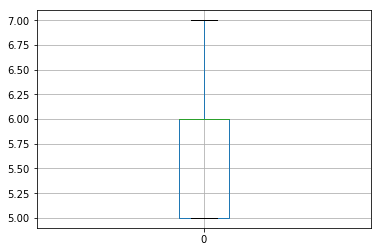

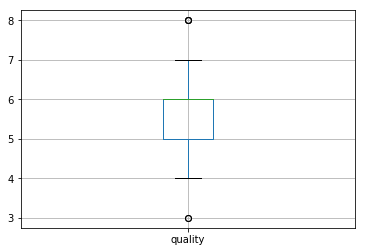

In [41]:
pd.DataFrame(guess_y).boxplot()
plt.show()
pd.DataFrame(test_y).boxplot()

In [42]:
test_y = test_y.astype('float64')

Text(0, 0.5, 'expected_y')

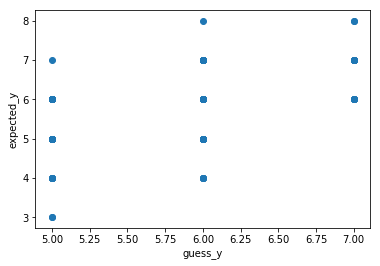

In [43]:
fig = plt.figure()
plt.scatter(guess_y, test_y)
plt.xlabel("guess_y")
plt.ylabel("expected_y")

In [107]:
guess_y.shape, test_y.shape
guessy = guess_y.tolist()
testy = test_y.tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'